In [0]:
import torch
from torch import nn 
from torch.nn import functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, OneCycleLR

import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode

import numpy as np 

import matplotlib.pyplot as plt  
import matplotlib.ticker as ticker

import os
import gc
import contextlib 

%matplotlib inline 
torch.manual_seed(0)

### Exploring Metadata

In [0]:
''' 
training dataset:   
        - Has shape (50000, 3, 32, 32) 
test dataset: 
        - Has shape (10000, 1) 
        - Each value is a label mapped to the following:

0: airplane										
1: automobile										
2: bird										
3: cat										
4: deer										
5: dog										
6: frog										
7: horse										
8: ship										
9: truck
'''
def load_data_cifar10(batch_size, resize=None, shuffle_train = False):
    """Download the CIFAR-10 dataset and then load it into memory."""
    
    train_trans = transforms.Compose(
            [ 
                # Flip the images randomly on the horizontal
                transforms.RandomHorizontalFlip(p=0.5),
                # Random perspective transformation  
                # transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
                # Randomly rotate some images by 20 degrees
                transforms.RandomRotation(20),
                # Randomly adjust color jitter of the images
                transforms.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
                # Randomly adjust sharpness
                transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
                # Turn the image into a torch.Tensor
                transforms.ToTensor() ,
                #randomly erase a pixel
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)
            ] 
        )

    test_trans = transforms.Compose(
        [  
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                std=[0.5, 0.5, 0.5]), 
        ]
    )
    # if resize:
    #     trans.insert(0, transforms.Resize(resize))
     
 
    # Download and create datasets
    cifar10_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform= train_trans, download=True)
    cifar10_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform= test_trans, download=True)

    # Create data loaders
    train_iter = torch.utils.data.DataLoader(
        cifar10_train, batch_size=batch_size, shuffle= shuffle_train, num_workers=2)
    
    test_iter = torch.utils.data.DataLoader(
        cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)
 
    return train_iter, test_iter

### Checking out a random picture with its associated tag

In [0]:
batch_size = 256
train_iter, test_iter = load_data_cifar10(batch_size, resize=None, shuffle_train = False)

for x_train , y_train in train_iter:
    print("Batch X shape:", x_train.shape)
    print("Batch y shape:", y_train.shape)
    break

for x_test , y_test in test_iter:
    print("Batch X shape:", x_test.shape)
    print("Batch y shape:", y_test.shape)
    break

cifar_labels = ['airplane',										
            'automobile',									
            'bird',								
            'cat',									
            'deer',										
            'dog',									
            'frog',										
            'horse',										
            'ship',									
            'truck'
        ]

Files already downloaded and verified
Files already downloaded and verified
Batch X shape: torch.Size([256, 3, 32, 32])
Batch y shape: torch.Size([256])
Batch X shape: torch.Size([256, 3, 32, 32])
Batch y shape: torch.Size([256])


In [0]:
torch.manual_seed(1)

class InterBlock(nn.Module):
    def __init__(self,
                device,
                conv_num_in_channels,
                num_convolutions,
                conv_out_channels,
                conv_kernel_size,
                conv_drop_prob,
                pool_bool= 0,
                batch_norm_bool= 0,
                out_block = False 
            ):  
        super(InterBlock, self).__init__() 
         
        self.device = device  
        self.out_block = out_block
        self.num_convolutions = num_convolutions
        self.conv_kernel_size = conv_kernel_size
        self.conv_out_channels = conv_out_channels
        self.pool_bool = pool_bool
        self.batch_norm_bool = batch_norm_bool
        self.conv_num_in_channels = conv_num_in_channels 
        

        self.compute_m = nn.AdaptiveAvgPool2d( (1,1) ).to(self.device)  ### Check that this is the same as the mean per channel
        self.FCL_a = nn.Linear(in_features= self.conv_num_in_channels,
                               out_features= self.num_convolutions,
                               bias = True
                        ).to(self.device) 

        
        self.LConvs = nn.ModuleList([
                            nn.Conv2d(in_channels= conv_num_in_channels, 
                                      out_channels= conv_out_channels,
                                      kernel_size= conv_kernel_size, 
                                      stride= 1,
                                      padding= 1,
                                      bias= True
                                    ) for _ in range(num_convolutions)
                            ]
            ).to(self.device)
        self.Relu = nn.ReLU()
        
        if self.batch_norm_bool:
            self.ConvBatchNorm = nn.BatchNorm2d(num_features= self.conv_out_channels).to(self.device)
        if self.pool_bool :
            self.MaxPooling = nn.MaxPool2d(kernel_size= 2, stride= 2) 
        if conv_drop_prob > 0:
            self.ConvDropout = nn.Dropout2d(p= conv_drop_prob)


        if self.out_block:
            self.FCL_out_1 = nn.Linear(in_features= conv_out_channels,
                                        out_features= 4096 ).to(self.device)
            self.FCL_out_2 = nn.Linear(in_features= 4096 ,
                                        out_features=1024 ).to(self.device)
            self.FCL_out_3 = nn.Linear(in_features= 1024 ,
                                        out_features=10).to(self.device) 
            
            self.OutDropout = nn.Dropout(p = 0.5)

        
    

    def compute_a(self, x):
        print(f'We will now compute the vector a: [a_1, ..., a_L] ')
        batch_size = x.shape[0]

        m = self.compute_m(x).reshape([batch_size, self.conv_num_in_channels]) 
        #print(f'm has shape {self.compute_m( x ).shape} and has been transformed to {m.shape} to be inputted in the FCL')
        
        a = self.FCL_a(m).to(self.device)  # input m into the FCL
        a = F.softmax(a, dim=1) 
                     
        print(f'FCL outputs [a] with shape {a.shape}')
        return a
    
    
    def compute_a_conv_sum(self, a, x): 
        #Computing the convolutions
        conv_outputs = []
        
        for i, conv in enumerate(self.LConvs): 
            print(f'Input x has shape {x.shape} and a has shape {a.shape}' )

            conv = conv(x)
            conv = self.ConvBatchNorm(conv) if self.batch_norm_bool else conv
            conv = self.Relu(conv)
            conv = self.MaxPooling(conv) if self.pool_bool else conv
            conv = self.ConvDropout(conv)

            # print(f'The {i}th element of a is {a[:,i]}')

            print(f'Each Convolution has output of shape {conv.shape}')
            conv_outputs.append( conv )   

        # 2. Stack them into a single tensor of shape (batch_size, num_convs, channels , w ,h)
        # i.e. we insert a new dimension at dim=1 to hold the "num_convs" dimension.
        conv_outputs_stacked = torch.stack(conv_outputs, dim=1).to(self.device)
        a = a.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(self.device)
        print(f'a has now has been transformed to {a.shape}.(we insert a new dimension at dim=1 to preserve the "num_convs" dimension)') 
        
        out = (conv_outputs_stacked * a).sum(dim=1)  
        print(f"Weighted convolution output image x' has shape {out.shape}") 
        return out


    def compute_out(self, x):
        print('OUTPUT LAYER:')
        batch_size = x.shape[0]
        print(f'x has shape {x.shape}') 

        m = self.compute_m( x ).reshape([batch_size, x.shape[1]]).to(self.device)
        print(f'm has shape {m.shape} and has been inputted in the FCL') 
        
        out = self.FCL_out_1(m)
        out = self.Relu(out)
        out = self.OutDropout(out)

        out = self.FCL_out_2(out) 
        out = self.Relu(out)
        out = self.OutDropout(out)
        
        out = self.FCL_out_3(out) 
        return out



    def forward(self, x):  

        x = x.to(device) 
        a = self.compute_a(x)

        out = self.compute_a_conv_sum(a, x)  
        if self.out_block:
            out = self.compute_out(out)

        return out  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = InterBlock( device,
                conv_num_in_channels= 3,
                num_convolutions = 4,
                conv_out_channels = 512,
                conv_kernel_size= 7,
                pool_bool= 0,
                batch_norm_bool= 1,  
                conv_drop_prob= 0.2,
                out_block= True  ).to(device)

def init_weights(m):
    # Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)   

model.apply(init_weights)
output = model(x_train)
print(output.shape)
model

We will now compute the vector a: [a_1, ..., a_L] 
FCL outputs [a] with shape torch.Size([256, 4])
Input x has shape torch.Size([256, 3, 32, 32]) and a has shape torch.Size([256, 4])
Each Convolution has output of shape torch.Size([256, 512, 28, 28])
Input x has shape torch.Size([256, 3, 32, 32]) and a has shape torch.Size([256, 4])
Each Convolution has output of shape torch.Size([256, 512, 28, 28])
Input x has shape torch.Size([256, 3, 32, 32]) and a has shape torch.Size([256, 4])
Each Convolution has output of shape torch.Size([256, 512, 28, 28])
Input x has shape torch.Size([256, 3, 32, 32]) and a has shape torch.Size([256, 4])
Each Convolution has output of shape torch.Size([256, 512, 28, 28])
a has now has been transformed to torch.Size([256, 4, 1, 1, 1]).(we insert a new dimension at dim=1 to preserve the "num_convs" dimension)
Weighted convolution output image x' has shape torch.Size([256, 512, 28, 28])
OUTPUT LAYER:
x has shape torch.Size([256, 512, 28, 28])
m has shape torch.S

InterBlock(
  (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
  (FCL_a): Linear(in_features=3, out_features=4, bias=True)
  (LConvs): ModuleList(
    (0-3): 4 x Conv2d(3, 512, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  )
  (Relu): ReLU()
  (ConvBatchNorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ConvDropout): Dropout2d(p=0.2, inplace=False)
  (FCL_out_1): Linear(in_features=512, out_features=4096, bias=True)
  (FCL_out_2): Linear(in_features=4096, out_features=1024, bias=True)
  (FCL_out_3): Linear(in_features=1024, out_features=10, bias=True)
  (OutDropout): Dropout(p=0.5, inplace=False)
)

In [0]:
def process_params(params):
    """
    Processes a dictionary of parameters to compute the input channels for each convolutional block.

    This function creates a list of input channels for a series of convolutional layers.
    It starts with 3 input channels (e.g., for RGB images) and appends the output channels
    of each preceding convolutional layer.

    Args:
        params (dict): A dictionary containing model parameters. It must include:
            - 'num_blocks' (int): Total number of convolutional blocks.
            - 'conv_output_layers' (list): Output channels for each convolutional block.

    Returns:
        dict: The updated parameters dictionary including the new key:
            - 'conv_input_channels' (list): Calculated input channels for each block.
    """
    conv_input_channels = [3]
    for i in range(params['num_blocks'] -1 ):
        c_in = params['conv_output_layers'][i]
        conv_input_channels.append(c_in)
    params['conv_input_channels'] = conv_input_channels

    return params 

In [0]:
class CNN(nn.Module):
    '''
    A modular deep Convolutional neural network (CNN) composed of multiple InterBlock modules.
    
    Each InterBlock module contains a set of convolutional layers followed by fully connected layers.
    The network is constructed by stacking a user-specified number of InterBlock modules.
    
    The final block (or the only block when num_blocks == 1) is configured as an output block, which
    processes the feature maps into final predictions (e.g., class scores). Intermediate blocks pass their
    outputs to subsequent blocks without producing final predictions.
    
    Args:
        num_blocks (int): Total number of InterBlock modules in the network.
        device (torch.device): Device on which to perform computation (e.g., 'cpu' or 'cuda').
        conv_nums_in_channels (list of int): Number of input channels for each InterBlock.
        num_convolutions (list of int): Number of convolutional layers in each InterBlock.
        conv_output_layers (list of int): Number of output channels for the final conv layer in each InterBlock.
        conv_kernel_sizes (list of int): Kernel size for each convolutional layer in each InterBlock.
        conv_pool_bools (list of bool): Whether to apply pooling after each conv layer in the InterBlock.
        conv_batch_norm_bools (list of bool): Whether to apply batch normalization after conv layers.
        conv_drop_probs (list of float): Dropout probabilities for each InterBlock.

    Limitations:
        - All list arguments must have a length equal to `num_blocks`.
        - Each InterBlock uses the corresponding element from each list to configure its layers.
        - The last InterBlock is treated as an output block 
        - The network currently assumes a fixed number of input channels (3) i.e. A batch of RGB images only as inputs. 
    
    The forward pass applies the InterBlock modules sequentially to the input.    
    
    '''


    def __init__(self,
            num_blocks,
            device,
            conv_nums_in_channels: list,
            num_convolutions: list,
            conv_output_layers: list,
            conv_kernel_sizes: list,
            conv_pool_bools: list,
            conv_batch_norm_bools: list,
            conv_drop_probs: list
        ):
        super(CNN, self).__init__() 
         
        self.device = device  
        self.num_blocks = len(num_convolutions)
        self.num_convolutions = num_convolutions
        self.conv_kernel_sizes = conv_kernel_sizes
        self.conv_output_layers = conv_output_layers
        self.conv_pool_bools = conv_pool_bools
        self.conv_batch_norm_bools = conv_batch_norm_bools
        self.conv_nums_in_channels = conv_nums_in_channels 
        

        assert num_blocks == len(num_convolutions) == len(conv_kernel_sizes) == len(conv_output_layers) == len(conv_pool_bools) == len(conv_batch_norm_bools) == len(conv_batch_norm_bools)
        
        
        if self.num_blocks == 1:
            self.Blocks = nn.ModuleList( [
                                InterBlock(device,
                                    num_convolutions = num_convolutions[0],
                                    conv_num_in_channels = conv_nums_in_channels[0],
                                    conv_out_channels = conv_output_layers[0],
                                    conv_kernel_size= conv_kernel_sizes[0],
                                    pool_bool = conv_pool_bools[0],
                                    batch_norm_bool= conv_batch_norm_bools[0],
                                    conv_drop_prob = conv_drop_probs[0],
                                    out_block= True)
                            ]
                        )
             
        else: 
            self.Blocks = nn.ModuleList(
                            [
                                InterBlock(device,
                                    num_convolutions = num_convolutions[0],
                                    conv_num_in_channels = conv_nums_in_channels[0],
                                    conv_out_channels = conv_output_layers[0],
                                    conv_kernel_size= conv_kernel_sizes[0],
                                    pool_bool = conv_pool_bools[0],
                                    batch_norm_bool= conv_batch_norm_bools[0],
                                    conv_drop_prob = conv_drop_probs[0],
                                    out_block= False
                                ) 
                        ]
                )
            for i in range(self.num_blocks - 2):
                self.Blocks.extend([
                                InterBlock(device,
                                    num_convolutions = num_convolutions[i+1],
                                    conv_num_in_channels = conv_nums_in_channels[i+1],
                                    conv_out_channels = conv_output_layers[i+1],
                                    conv_kernel_size= conv_kernel_sizes[i+1],
                                    pool_bool = conv_pool_bools[i+1],
                                    batch_norm_bool= conv_batch_norm_bools[i+1],
                                    conv_drop_prob = conv_drop_probs[i+1],
                                    out_block= False) 
                                ]
                            )
            self.Blocks.extend([
                                InterBlock(device,
                                    num_convolutions = num_convolutions[num_blocks-1],
                                    conv_num_in_channels = conv_nums_in_channels[num_blocks-1],
                                    conv_out_channels = conv_output_layers[num_blocks-1],
                                    conv_kernel_size= conv_kernel_sizes[num_blocks-1],
                                    pool_bool = conv_pool_bools[num_blocks-1],
                                    batch_norm_bool= conv_batch_norm_bools[num_blocks-1],
                                    conv_drop_prob = conv_drop_probs[num_blocks-1],
                                    out_block= True)
                            ]    
                        )
    

    def forward(self, x):
        print(f'\nExecuting 1st block with input {x.shape[0]} images of size {x.shape[1:]}')          
        out = self.Blocks[0](x)

        if self.num_blocks > 1:
            for i, block in enumerate(self.Blocks[1:]):
                print(f'\nExecuting block No.{i+2} with input {out.shape[0]} images of size {out.shape[1:]}')
                out = block(out)  

        return  out
     

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
num_same_blocks = 3
params = { 'num_blocks' : num_same_blocks,
        'num_convolutions': num_same_blocks*[4] ,
        'conv_output_layers':  [32, 64, 128],
        'conv_kernel_sizes': num_same_blocks*[7] ,
        'conv_pool_bools': num_same_blocks*[1],
        'conv_batch_norm_bools': num_same_blocks*[1],
        'conv_drop_probs' : [0.2, 0.3, 0.4]
        }

params = process_params(params)
model = CNN(
            device= device,
            conv_nums_in_channels = params['conv_input_channels'],
            num_blocks= params['num_blocks'],
            num_convolutions= params['num_convolutions'],
            conv_output_layers= params['conv_output_layers'],
            conv_kernel_sizes= params['conv_kernel_sizes'],
            conv_pool_bools= params['conv_pool_bools'],
            conv_batch_norm_bools= params['conv_batch_norm_bools'],  
            conv_drop_probs = params['conv_drop_probs']
        ).to(device) 

# print(model(x_train).shape)
model

CNN(
  (Blocks): ModuleList(
    (0): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=3, out_features=4, bias=True)
      (LConvs): ModuleList(
        (0-3): 4 x Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
      )
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (ConvDropout): Dropout2d(p=0.2, inplace=False)
    )
    (1): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=32, out_features=4, bias=True)
      (LConvs): ModuleList(
        (0-3): 4 x Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
      )
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (MaxPooling): MaxPool2d(kernel_size=2

In [0]:
def evaluate_metric(model, data_iter, metric, device):
    """Compute the average `metric` of the model on a dataset.""" 
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    model = model.to(device)
    
    for X, y in data_iter: 
        logits = model(X).to(device)
        c += metric(logits, y.to(device)).to(device)
        n += len(y)  
    return c / n


def correct(logits, y):
    y_hat = logits.argmax(axis=1).to(device) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [0]:
batch_size = 256
train_iter, test_iter = load_data_cifar10(batch_size, resize=None, shuffle_train = True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

num_same_blocks = 10 
max_pooling = int(num_same_blocks/2) * [False, True]
dropout_probs = [ 0.2 + (int(x)*0.0225) for x in range(num_same_blocks)]


params = { 'num_blocks' : num_same_blocks,
        'num_convolutions': num_same_blocks * [3] ,
        'conv_output_layers':  [64, 64, 128, 128, 256, 256, 512, 512, 512, 512],
        'conv_kernel_sizes': num_same_blocks* [3] ,
        'conv_drop_probs': dropout_probs,
        'conv_pool_bools': max_pooling, 
        'conv_batch_norm_bools': num_same_blocks*[1], 
        } 
params = process_params(params)
model = CNN(
            device= device,
            conv_nums_in_channels = params['conv_input_channels'],
            num_blocks= params['num_blocks'],
            num_convolutions= params['num_convolutions'],
            conv_output_layers= params['conv_output_layers'],
            conv_kernel_sizes= params['conv_kernel_sizes'],
            conv_pool_bools= params['conv_pool_bools'],
            conv_batch_norm_bools= params['conv_batch_norm_bools'], 
            conv_drop_probs= params['conv_drop_probs']
        ).to(device)     
print(model)
 

momentum = 0.9
num_epochs = 600 

learning_rate = 0.05
weight_decay = 1e-4
lr_step_size= 10 
init_weight = True

 
def init_weights(m):
        # Applies initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):  
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
if init_weights:
        model.apply(init_weights)


losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

cross_entropy_loss = torch.nn.CrossEntropyLoss()
scaler = GradScaler()
optimizer = torch.optim.SGD(model.parameters(), 
                lr=learning_rate,
                momentum= momentum,
                weight_decay= weight_decay
        ) 
scheduler = OneCycleLR(optimizer,
                        max_lr= learning_rate,
                        total_steps= 2000, ) 


for epoch in range(num_epochs):
        for x_train, y_train in train_iter:
                with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
                        with autocast(): #Autocasting automatically chooses the precision for operations to improve performance while maintaining accuracy.
                                logits = model(x_train).to(device) 
                                l = cross_entropy_loss(logits , y_train.to(device)) # Computes the loss given the `logits` and the class vector `y`
                optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
 
                scaler.scale(l).backward() # Computes the gradient of the loss `l` with respect to the model parameters
                 
                scaler.step(optimizer) # Updates the model parameters based on the gradients stored inside them
                scaler.update() 
                losses.append(float(l)) # Stores the loss for this batch

        scheduler.step()
        with torch.no_grad(): # Computing performance metrics does not require gradients
                with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):        
                        train_accs.append( evaluate_metric(model, train_iter , correct, device)  ) 
                        test_accs.append( evaluate_metric(model, test_iter, correct, device) ) 

                if epoch % lr_step_size == 0:
                        print(f'\nUpdated Learning rate: {scheduler.get_last_lr()[0]}')
                if epoch % 10 == 0 or epoch <= 9:                
                        print(f'\nEpoch {epoch + 1}/{num_epochs}.') 
                        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}.')
                

dict_results = {'training_accuracies': train_accs,
                'testing_accuracies': test_accs,
                'cross_entropy_losses': losses,
                'learning_rate': learning_rate,
                'momentum': momentum,
                'weight_decay': weight_decay,
                'model': model
        }


# plot_train_test_acc(train_accs, test_accs)
dict_results

### CNN Architecture

```python
CNN(
  (Blocks): ModuleList(
    (0): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=3, out_features=3)
      (LConvs): ModuleList(
        (0-2): 3 x Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
      )
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(64)
      (ConvDropout): Dropout2d(p=0.2)
    )
    (1): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=64, out_features=3)
      (LConvs): 3 x Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(64)
      (MaxPooling): MaxPool2d(kernel_size=2, stride=2)
      (ConvDropout): Dropout2d(p=0.2225)
    )
    (2): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=64, out_features=3)
      (LConvs): 3 x Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(128)
      (ConvDropout): Dropout2d(p=0.245)
    )
    (3): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=128, out_features=3)
      (LConvs): 3 x Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(128)
      (MaxPooling): MaxPool2d(kernel_size=2, stride=2)
      (ConvDropout): Dropout2d(p=0.2675)
    )
    (4): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=128, out_features=3)
      (LConvs): 3 x Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(256)
      (ConvDropout): Dropout2d(p=0.29)
    )
    (5): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=256, out_features=3)
      (LConvs): 3 x Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(256)
      (MaxPooling): MaxPool2d(kernel_size=2, stride=2)
      (ConvDropout): Dropout2d(p=0.3125)
    )
    (6): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=256, out_features=3)
      (LConvs): 3 x Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(512)
      (ConvDropout): Dropout2d(p=0.335)
    )
    (7): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=512, out_features=3)
      (LConvs): 3 x Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(512)
      (MaxPooling): MaxPool2d(kernel_size=2, stride=2)
      (ConvDropout): Dropout2d(p=0.3575)
    )
    (8): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=512, out_features=3)
      (LConvs): 3 x Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(512)
      (ConvDropout): Dropout2d(p=0.38)
    )
    (9): InterBlock(
      (compute_m): AdaptiveAvgPool2d(output_size=(1, 1))
      (FCL_a): Linear(in_features=512, out_features=3)
      (LConvs): 3 x Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
      (Relu): ReLU()
      (ConvBatchNorm): BatchNorm2d(512)
      (MaxPooling): MaxPool2d(kernel_size=2, stride=2)
      (ConvDropout): Dropout2d(p=0.4025)
      (FCL_out_1): Linear(in_features=512, out_features=4096)
      (FCL_out_2): Linear(in_features=4096, out_features=1024)
      (FCL_out_3): Linear(in_features=1024, out_features=10)
      (OutDropout): Dropout(p=0.5)
    )
  )
)


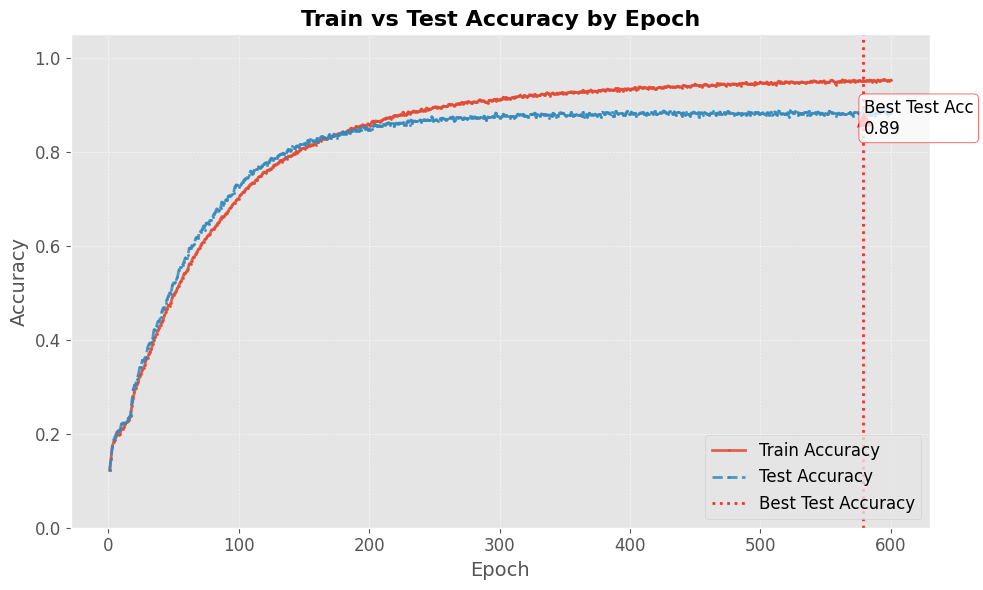

In [0]:
def plot_train_test_acc(train_accs, test_accs): 
    epochs = range(1, len(train_accs) + 1)

    plt.figure(figsize=(10, 6))
     
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o', linestyle='-', linewidth=2, markersize=1, alpha=0.85)
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='s', linestyle='--', linewidth=2, markersize=1, alpha=0.85)

    # Find highest test accuracy and its epoch
    best_epoch = test_accs.index(max(test_accs)) + 1
    best_acc = test_accs[best_epoch - 1]
 
    plt.axvline(x=best_epoch, color='red', linestyle=':', linewidth=2, alpha=0.8, label='Best Test Accuracy')
 
    plt.annotate(f'Best Test Acc\n{best_acc:.2f}',
                 xy=(best_epoch, best_acc),
                 xytext=(best_epoch + 0.5, best_acc - 0.05),
                 arrowprops=dict(facecolor='red', shrink=0.05, width=2),
                 fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white', alpha=0.8))
 
    plt.title('Train vs Test Accuracy by Epoch', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
 
    plt.ylim(0, 1.05)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
 
    plt.legend(fontsize=12, loc='lower right')

    plt.tight_layout()
    plt.show()



train_accs = (torch.tensor(train_accs).cpu().numpy())
test_accs = (torch.tensor(test_accs).cpu().numpy())

plot_train_test_acc(train_accs.tolist(), test_accs.tolist())

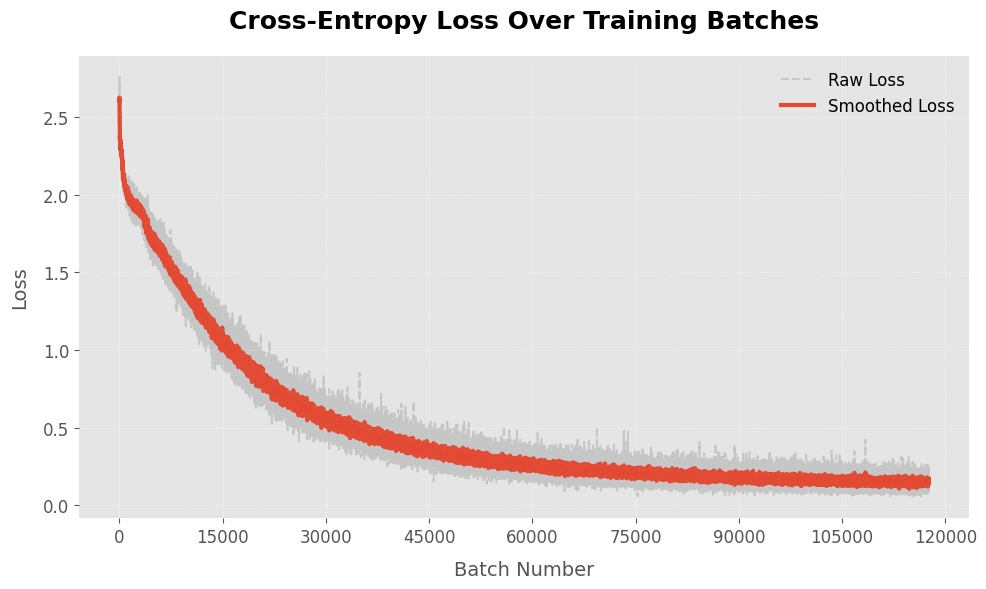

In [0]:
def plot_losses(losses): 
    num_batches = range(1, len(losses) + 1)
 
    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(10, 6))

    # Smoothing for visual aesthetics
    smooth_losses = np.convolve(losses, np.ones(10)/10, mode='valid')
    smooth_batches = range(1 + 5, len(losses) - 3)
 
    ax.plot(num_batches, losses, linestyle='--', alpha=0.3, color='gray', label='Raw Loss')

    # Plot smoothed line with rounded markers
    ax.plot(smooth_batches, smooth_losses, linewidth=3, marker='o', markersize=.2, 
            markerfacecolor='white', markeredgewidth=1, label='Smoothed Loss')
 
    ax.set_title('Cross-Entropy Loss Over Training Batches', fontsize=18, weight='bold', pad=20)
    ax.set_xlabel('Batch Number', fontsize=14, labelpad=10)
    ax.set_ylabel('Loss', fontsize=14, labelpad=10) 
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.tick_params(axis='both', labelsize=12)
 
    ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7) 
    ax.legend(fontsize=12, frameon=False)
 
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.show()

losses = (torch.tensor(losses).cpu().numpy())
plot_losses(losses)

In [0]:

# print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
# print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
# print(f"Total device memory: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.2f} MB") 

# torch.cuda.empty_cache() 
# reset_gpu()

# print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
# print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
# print(f"Total device memory: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.2f} MB") 